In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

Загружаем данные в рабочую среду

In [2]:
data = pd.read_csv('02_adult.csv', na_values='?')
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Проверяем данные на пропуски

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
data.isna().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

Удаляем пропуски

In [6]:
data = data[~(data['workclass'].isna())]
data = data[~(data['occupation'].isna())]
data = data[~(data['native-country'].isna())]

Пропусков не осталось

In [7]:
data.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

Просмотрим данные более детально

In [8]:
education = data[['education', 'educational-num']].drop_duplicates()
education.sort_values('educational-num').reset_index(drop=True)

,education,educational-num
0,Preschool,1
1,1st-4th,2
2,5th-6th,3
3,7th-8th,4
4,9th,5
5,10th,6
6,11th,7
7,12th,8
8,HS-grad,9
9,Some-college,10


Значения столбца educational-num соответствуют образованию в education и проставлены от наименьшего уровня образования к наибольшему, далее будем учитывать только один из столбцов

In [9]:
data = data.drop('education', axis=1)

Отберем столбцы с теми данными, которые кажутся более связанными с доходом, и посмотрим на их связь с income с помощью столбчатых диаграмм, а так же оценим уровни корреляции

In [10]:
columns = ['educational-num', 'workclass', 'marital-status', 'occupation',
           'relationship', 'race', 'gender', 'native-country', 'income']

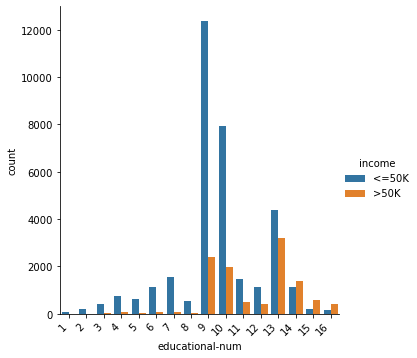

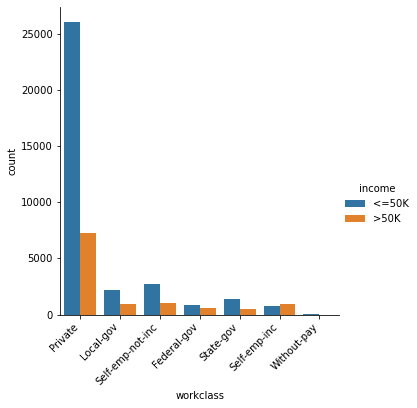

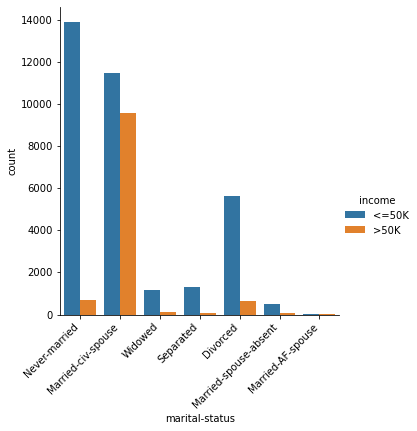

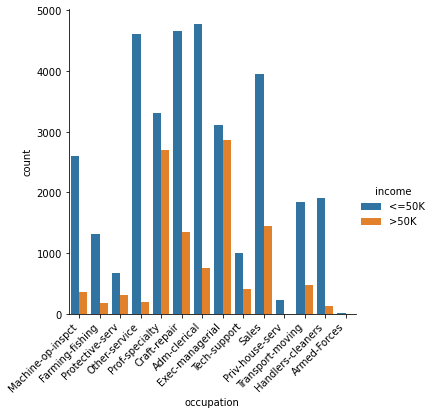

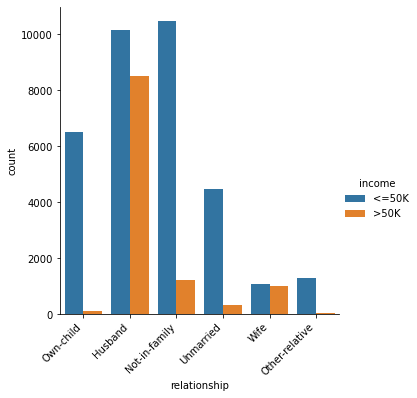

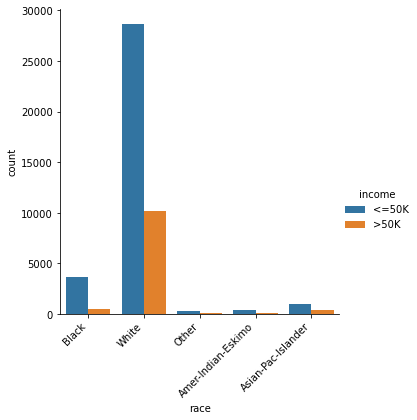

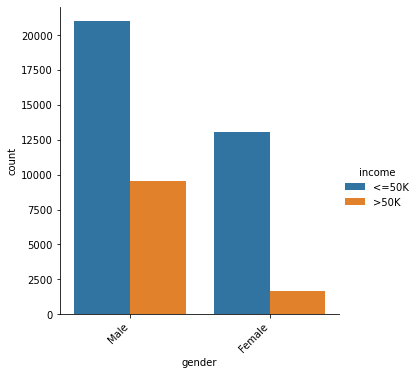

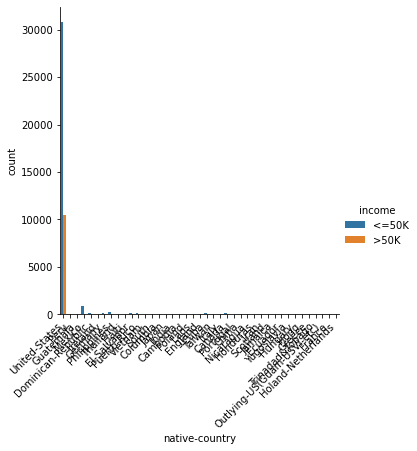

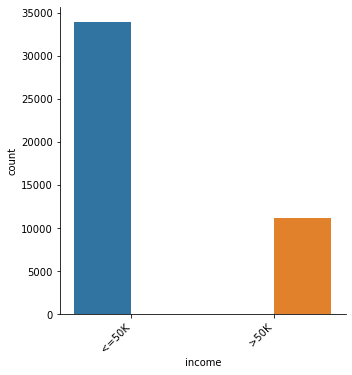

In [11]:
for column in columns:
    plot = sns.catplot(x=column, hue='income', data=data, kind='count')
    plot.set_xticklabels(rotation=45, horizontalalignment='right')

<AxesSubplot:>

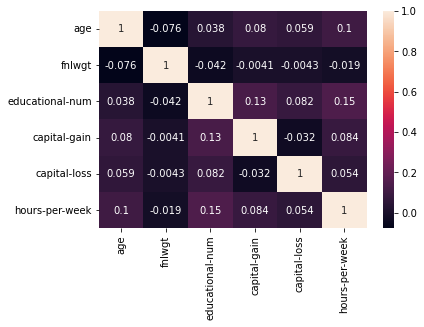

In [12]:
sns.heatmap(data.corr(), annot=True, cmap="rocket")

Нет сильно коррелированных признаков, и, судя по столбчатым диаграммам, у каждого из проверенных признаков есть влияние на целевую переменную. Кроме столбца education, который дублирует educational-num ничего не удаляем и переходим к преобразованию данных.

Преобразуем категориальные признаки

In [13]:
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship',
                        'race', 'gender', 'native-country']

In [14]:
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

In [15]:
data.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,<=50K,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,<=50K,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,>50K,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,>50K,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,34,198693,6,0,0,30,<=50K,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
X = data.drop('income', axis=1)

In [17]:
le = LabelEncoder()

In [18]:
le.fit(data['income'])

LabelEncoder()

In [19]:
y = pd.Series(data=le.transform(data['income']))
y.head()

0    0
1    0
2    1
3    1
4    0
dtype: int32

In [20]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

Разделим выборку на обучающее и тестовое подмножество. 80% данных оставим на обучающее множество, 20% на тестовое.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [23]:
model.score(X_train, y_train)

0.8484672582027255

In [24]:
model.score(X_test,y_test)

0.8507462686567164

Посмотрим на результат без StandardScaler

In [25]:
without_stscaler = LogisticRegression(max_iter=1000)
without_stscaler.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [26]:
without_stscaler.score(X_train, y_train)

0.7903640434530227

In [27]:
without_stscaler.score(X_test,y_test)

0.7955776672194582

Результат без StandardScaler явно хуже, чем с ним

Перейдем к методу опорных векторов, для начала так же с использованием пайплайнов

In [28]:
clf = make_pipeline(StandardScaler(), SVC())
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [29]:
clf.score(X_train, y_train)

0.8542996931752218

In [30]:
clf.score(X_test, y_test)

0.8519624101713654

Добавим kernel='poly' для возведения в степень

In [31]:
clf_poly = make_pipeline(StandardScaler(), SVC(kernel='poly'))
clf_poly.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly'))])

In [32]:
clf_poly.score(X_train, y_train)

0.8415291483539266

In [33]:
clf_poly.score(X_test, y_test)

0.8320619126589276

Теперь посмотрим на результат без StandardScaler

In [34]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [35]:
svc.score(X_train, y_train)

0.7895624291677033

In [36]:
svc.score(X_test, y_test)

0.7946932006633499

И здесь тоже добавим kernel='poly' для возведения в степень

In [37]:
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_train, y_train)

SVC(kernel='poly')

In [38]:
svc_poly.score(X_train, y_train)

0.7734195759736849

In [39]:
svc_poly.score(X_test, y_test)

0.7789939192924268

Подведем итоги

Наилучший результат показал метод опорных векторов с использованием пайплайнов для масштабирования.

Наихудший результат выдал тот же метод, но без пайплайнов и с возведением в степень, и это явно того не стоило, потому что модель обучалась ровно 2 часа :)